In [1]:
from cox.store import Store
from cox.readers import CollectionReader
import pandas as pd
import numpy as np
import torch
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import torch.nn.functional as F

In [3]:
import sys
sys.path.append("../")

In [4]:
from utils.data import BanditDataset
from alg.iw import IW
from alg.q import QLearning

In [13]:
from matplotlib import rc

rc('font', **{'family':'serif','serif':['Times New Roman']})
rc('text', usetex=True)
rc('xtick', labelsize=12) 
rc('ytick', labelsize=12) 
rc('legend', fontsize=12) 
rc('axes', titlesize=16, labelsize=18) 

rc('pdf', fonttype=42)
rc('ps', fonttype=42)

In [14]:
def get_df(alg, model, actions, lr, offset, wd):
    if alg == 'iw':
        file_name = 'cifar_sweep_alg=' + alg + '_model=' + model + '_actions=' + actions +\
                            '_lr=' + str(lr) + '_wd=' + str(wd)  + '_offset=' + str(offset)
    else:
        file_name = 'cifar_sweep_alg=' + alg + '_model=' + model + '_actions=' + actions +\
                            '_lr=' + str(lr) + '_wd=' + str(wd) 
    s = Store('../cox_logs', file_name, mode='r')
    df = s['learning_curves'].df
    s.close()
    return df

def get_lc(df, mode, quantity):
    lc = df[df['mode'] == mode][quantity].to_numpy()
    return lc

def get_final(alg, model, actions, lr, offset, wd, mode, quantity):
    df = get_df(alg, model, actions, lr, offset, wd)
    lc = get_lc(df, mode, quantity)
    return lc[-1]

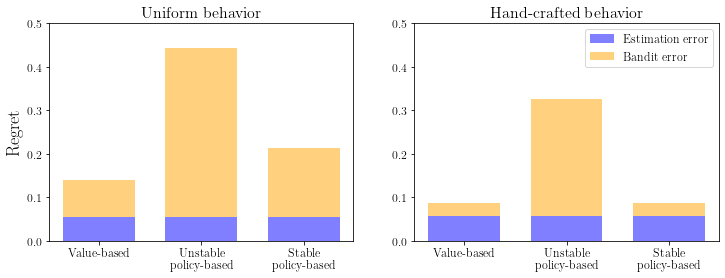

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

actions = 'blbf'
mode = 'test'
quantity = 'reward'
offset = 0.0
wd = 0.0001


def plot(ax, actions):

    iwu = get_final('iw', 'resnet', actions, 0.1, 0.1, wd, mode, quantity)
    iws = get_final('iw', 'resnet', actions, 0.1, -0.1, wd, mode, quantity)
    q = get_final('q', 'resnet', actions, 0.1, 0.1, wd, mode, quantity)
    ff = get_final('ff', 'resnet', actions, 0.1, 0.1, wd, mode, quantity)

    opt = 1.0


    ee = opt - ff

    iwu_be = ff - iwu
    iws_be = ff - iws
    q_be = ff - q



    ax.bar(0, ee, color='blue', width=0.7, alpha=0.5)
    ax.bar(0, q_be, bottom=ee, color='orange', width=0.7, alpha=0.5)

    ax.bar(1, ee, color='blue', width=0.7, alpha=0.5)
    ax.bar(1, iwu_be, bottom=ee, color='orange', width=0.7, alpha=0.5)

    ax.bar(2, ee, color='blue', label='Estimation error', width=0.7, alpha=0.5)
    ax.bar(2, iws_be, bottom=ee, color='orange', label='Bandit error', width=0.7, alpha=0.5)
    
    if actions == 'uniform_0':
        ax.set_ylabel('Regret')
    else:
        ax.legend()
    ax.set_ylim(0.0, 0.5)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(['Value-based', 'Unstable\n policy-based', 'Stable\n policy-based'])

    
    
plot(axes[0], 'uniform_0')
axes[0].set_title('Uniform behavior')

plot(axes[1], 'blbf')
axes[1].set_title('Hand-crafted behavior')

plt.savefig('cifar_regret_bar.pdf', dpi=300, bbox_inches='tight')
plt.show()

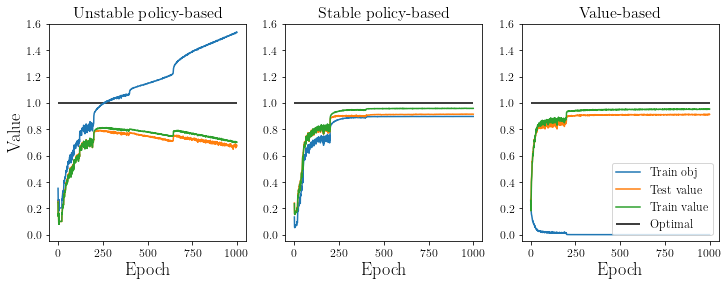

In [17]:
actions = 'blbf'

def plot_lc(df, ax, title):
    lc = get_lc(df, 'train', 'loss')
    if title != "Value-based":
        ax.plot(-lc, label='Train obj')
    else:
        ax.plot(lc, label='Train obj')

    lc = get_lc(df, 'test', 'reward')
    ax.plot(lc, label='Test value')
        
    ax.hlines(1.0, 0,1000, label='Optimal', color='black')

    lc = get_lc(df, 'train', 'reward')
    ax.plot(lc, label='Train value')
    
    # opt, rand = get_opt_and_rand("train", n, d, K, nbad, gamma, epsilon, seed, a_s)
    # plt.hlines(opt, 0,1000, label='train optimal', color='red')

    #plt.hlines(rand, 0,1000, label='rand', color='blue')

    ax.set_xlabel('Epoch')
    if title == "Unstable policy-based":
        ax.set_ylabel('Value')
    ax.set_title(title)
    ax.set_ylim(-0.05, 1.6)
    #plt.ylim(-11, 1.2)
    if title == "Value-based":
        ax.legend(loc='lower right')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
    
df = get_df('iw', 'resnet', actions, 0.1, 0.1, wd)
plot_lc(df, axes[0], "Unstable policy-based")

df = get_df('iw', 'resnet', actions, 0.1, -0.1, wd)
plot_lc(df, axes[1], "Stable policy-based")

df = get_df('q', 'resnet', actions, 0.1, -0.1, wd)
plot_lc(df, axes[2], "Value-based")
    
plt.savefig('cifar_learning_' + actions + '.pdf', dpi=300, bbox_inches='tight')
plt.show()

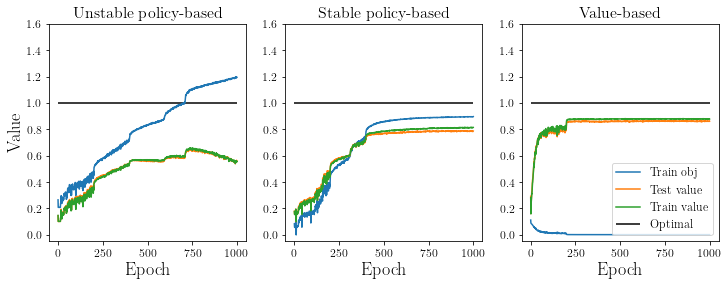

In [18]:
actions = 'uniform_0'

def plot_lc(df, ax, title):
    lc = get_lc(df, 'train', 'loss')
    if title != "Value-based":
        ax.plot(-lc, label='Train obj')
    else:
        ax.plot(lc, label='Train obj')

    lc = get_lc(df, 'test', 'reward')
    ax.plot(lc, label='Test value')
        
    ax.hlines(1.0, 0,1000, label='Optimal', color='black')

    lc = get_lc(df, 'train', 'reward')
    ax.plot(lc, label='Train value')
    
    # opt, rand = get_opt_and_rand("train", n, d, K, nbad, gamma, epsilon, seed, a_s)
    # plt.hlines(opt, 0,1000, label='train optimal', color='red')

    #plt.hlines(rand, 0,1000, label='rand', color='blue')

    ax.set_xlabel('Epoch')
    if title == "Unstable policy-based":
        ax.set_ylabel('Value')
    ax.set_title(title)
    ax.set_ylim(-0.05, 1.6)
    #plt.ylim(-11, 1.2)
    if title == "Value-based":
        ax.legend(loc='lower right')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
    
df = get_df('iw', 'resnet', actions, 0.1, 0.1, wd)
plot_lc(df, axes[0], "Unstable policy-based")

df = get_df('iw', 'resnet', actions, 0.1, -0.1, wd)
plot_lc(df, axes[1], "Stable policy-based")

df = get_df('q', 'resnet', actions, 0.1, -0.1, wd)
plot_lc(df, axes[2], "Value-based")
    
plt.savefig('cifar_learning_' + actions + '.pdf', dpi=300, bbox_inches='tight')
plt.show()

0.5558524131774902


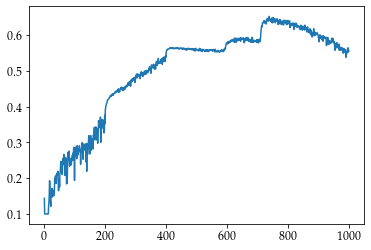

In [19]:
alg = 'iw'
actions = 'uniform_0'
mode = 'test'
quantity = 'reward'
offset = 0.1
wd = 0.0001

df = get_df(alg, 'resnet', actions, 0.1, offset, wd)
lc = get_lc(df, mode, quantity)

print(lc[-1])

plt.plot(lc)
plt.show()

ff 0.0 0.9432120323181152
q 0.0 0.9128
iw -0.1 0.9139955043792725
iw 0.1 0.6736689209938049


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


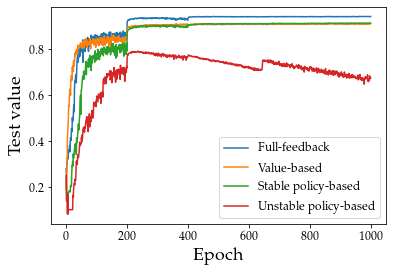

In [9]:
algs = ['ff', 'q', 'iw-','iw+']
labels = ['Full-feedback', 'Value-based', 'Stable policy-based', 'Unstable policy-based']

actions = 'blbf'
mode = 'test'
quantity = 'reward'
offset = 0.0
wd = 0.0001
label = ''

for i, alg in enumerate(algs):
    if alg == 'iw+':
        alg = 'iw'
        offset = 0.1
    if alg == 'iw-':
        alg = 'iw'
        offset = -0.1
    
    
    df = get_df(alg, 'resnet', actions, 0.1, offset, wd)
    lc = get_lc(df, mode, quantity)

    print(alg, offset, lc[-1])

    plt.plot(lc, label = labels[i])

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Test value')
plt.show()

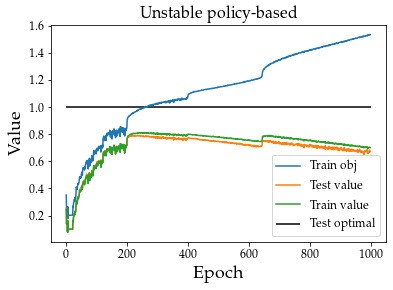

In [21]:
actions = 'blbf'
mode = 'test'
quantity = 'reward'
offset = 0.0
wd = 0.0001
label = ''

df = get_df('iw', 'resnet', actions, 0.1, 0.1, wd)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))

lc = get_lc(df, 'train', 'loss')
ax.plot(-lc, label='Train obj')

lc = get_lc(df, 'test', 'reward')
ax.plot(lc, label='Test value')

lc = get_lc(df, 'train', 'reward')
ax.plot(lc, label='Train value')

ax.hlines(1.0, 0, 1000, label= 'Test optimal', color='black')

ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Value')

ax.set_title('Unstable policy-based')

#plt.savefig('cifar_learning.png', dpi=300)

plt.show()

In [ ]:
def SetPlotRC():
    #If fonttype = 1 doesn't work with LaTeX, try fonttype 42.
    plt.rc('pdf',fonttype = 1)
    plt.rc('ps',fonttype = 1)

def ApplyFont(ax):

    ticks = ax.get_xticklabels() + ax.get_yticklabels()

    text_size = 14.0

    for t in ticks:
        t.set_fontname('Times New Roman')
        t.set_fontsize(text_size)

    txt = ax.get_xlabel()
    txt_obj = ax.set_xlabel(txt)
    txt_obj.set_fontname('Times New Roman')
    txt_obj.set_fontsize(text_size)

    txt = ax.get_ylabel()
    txt_obj = ax.set_ylabel(txt)
    txt_obj.set_fontname('Times New Roman')
    txt_obj.set_fontsize(text_size)

    txt = ax.get_title()
    txt_obj = ax.set_title(txt)
    txt_obj.set_fontname('Times New Roman')
    txt_obj.set_fontsize(text_size)